# Analyses of entanglement


### "Sweep through generative factors and plot/quantify effect in the latents"


In [1]:
import torch
import pickle

import sys
# Adds higher directory to python modules path.
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

sys.path.append("../analyses")
from analyses import *

In [58]:
def colorAxisNormalize(colorbar):
    cm = np.max(np.abs(colorbar.get_clim()))
    colorbar.set_clim(-cm,cm)

### model: staticVAE32 (standard VAE)


In [2]:
from staticvae.models import staticVAE32

vae = staticVAE32(n_latent = 4)
vae.eval()
checkpoint = torch.load('../staticvae/trained/staticvae32_dsprites_circle_last_500K',map_location='cpu')
vae.load_state_dict(checkpoint['model_states']['net'])

training_stats = pickle.load(open('../staticvae/trained/staticvae32_dsprites_circle_500K.pkl', 'rb'))

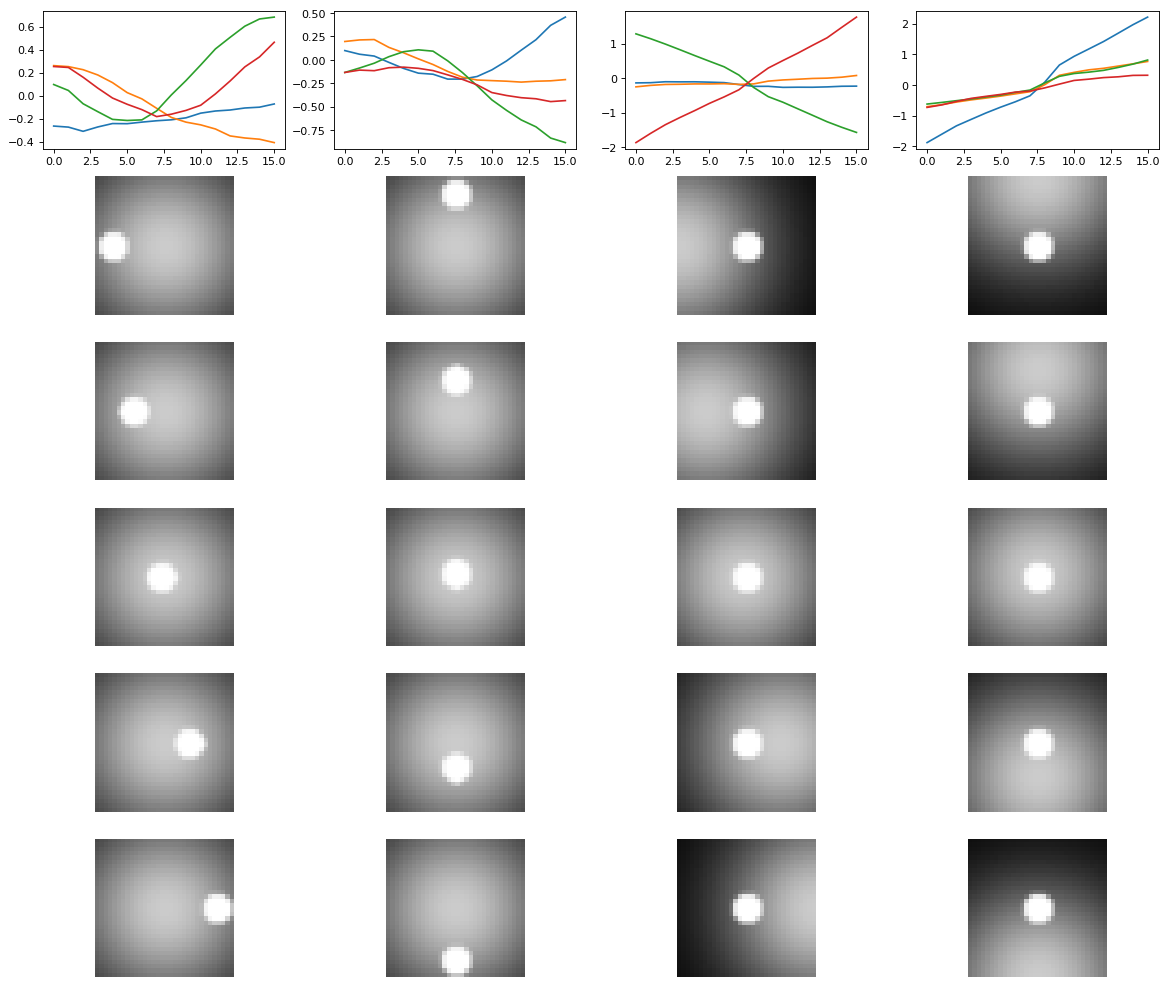

In [48]:
yhat_vae, x_vae = sweepCircleLatents(vae)
plotCircleSweep(yhat_vae, x_vae)

Columns, from left to right: sweeps through circle horizontal position, circle vertical position, gaussian background horizontal position, gaussian background vertical position

Top row shows latent variable representations as a function of the stimulus sweeps.

***VAE latent representations are entangled.***

Though the Gaussian position variables are at least monotonically changing---a step towards distentanglement

#### Plot correlation matrix

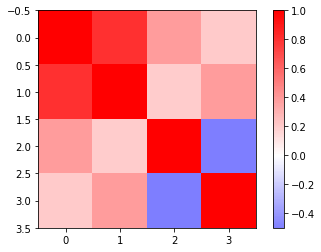

In [59]:
corr_vae = np.corrcoef(yhat_vae.detach().numpy().T)
# Plot covariance
plt.set_cmap('bwr')
plt.imshow(corr_vae)
colorAxisNormalize(plt.colorbar())

There is significant cross-correlation (positive and negative) between some, but not all latent variables, indicating some entanglement.

### model: $\beta$-VAE-like *supervised* encoder


In [51]:
from supervised_encoderdecoder.models.encoders import encoderBVAE_like

supervised = encoderBVAE_like(n_latent=4)

checkpoint = torch.load('../supervised_encoderdecoder/trained/encoderbvae_like_dsprites_circle_last_50K')
supervised.load_state_dict(checkpoint['model_states']['net'])

training_stats = pickle.load(open('../supervised_encoderdecoder/trained/encoderbvae_like_dsprites_circle_50K.pkl', 'rb'))

supervised.n_latent = supervised.fc.out_features

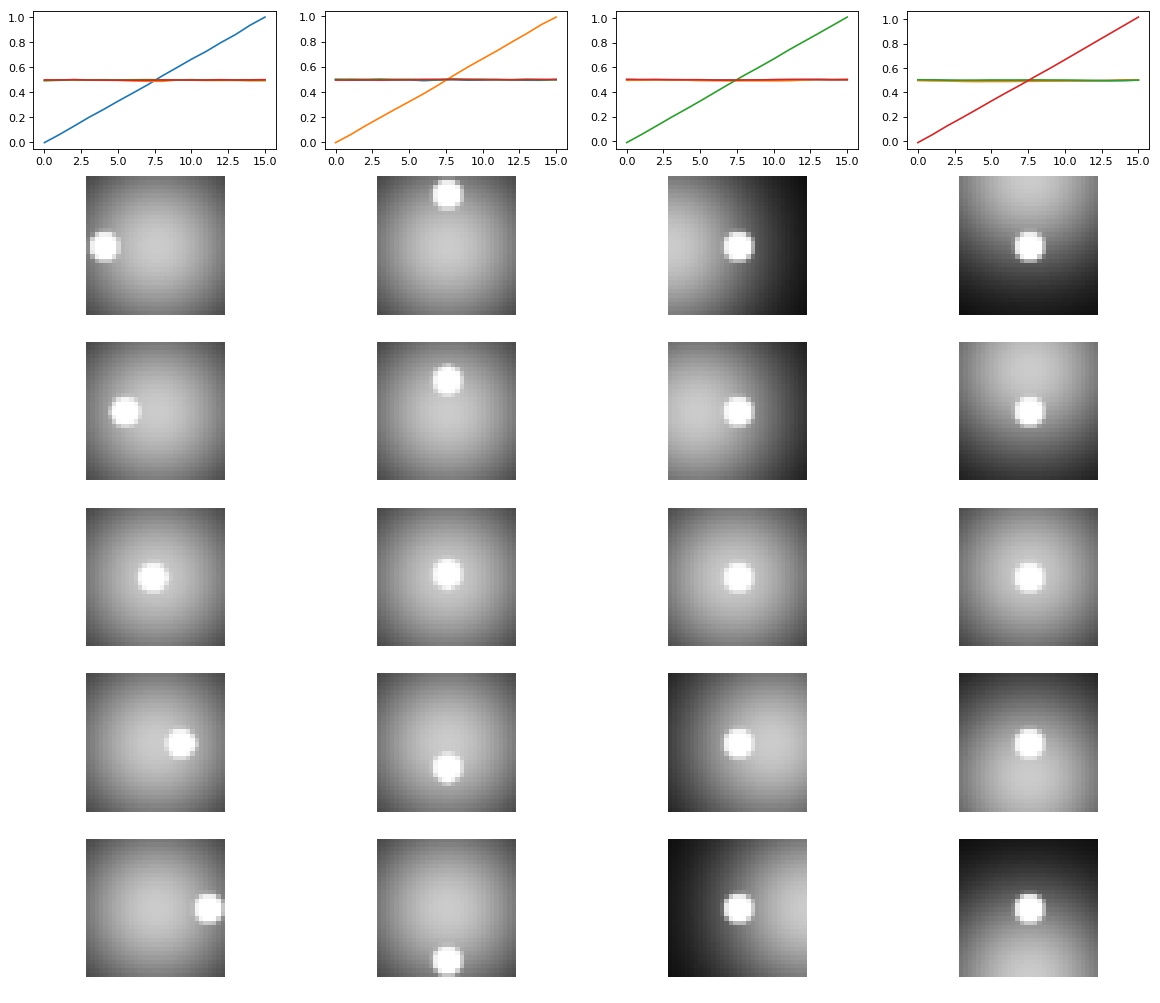

In [52]:
yhat_sup, x_sup = sweepCircleLatents(supervised)
plotCircleSweep(yhat_sup, x_sup)

Same as previous figure, but for supervised encoder.

***Supervised latent representations are perfectly disentangled.***

This was to be expected, but good to validate.

#### Plot correlation matrix

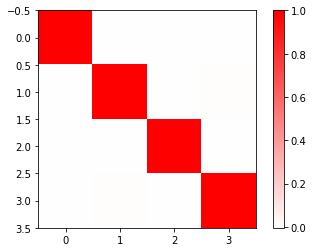

In [60]:
corr_sup = np.corrcoef(yhat_sup.detach().numpy().T)
# Plot covariance
plt.set_cmap('bwr')
plt.imshow(corr_sup)
colorAxisNormalize(plt.colorbar())

As seen from latent plots, there is no cross-correlation between latent variables, indicating perfect disentanglement

## Analyzing posterior variance

In [66]:
recon = vae.decode(yhat_vae)
recon.ve

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: shape '[64]' is invalid for input of size 65536

/Users/zaharia/Library/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


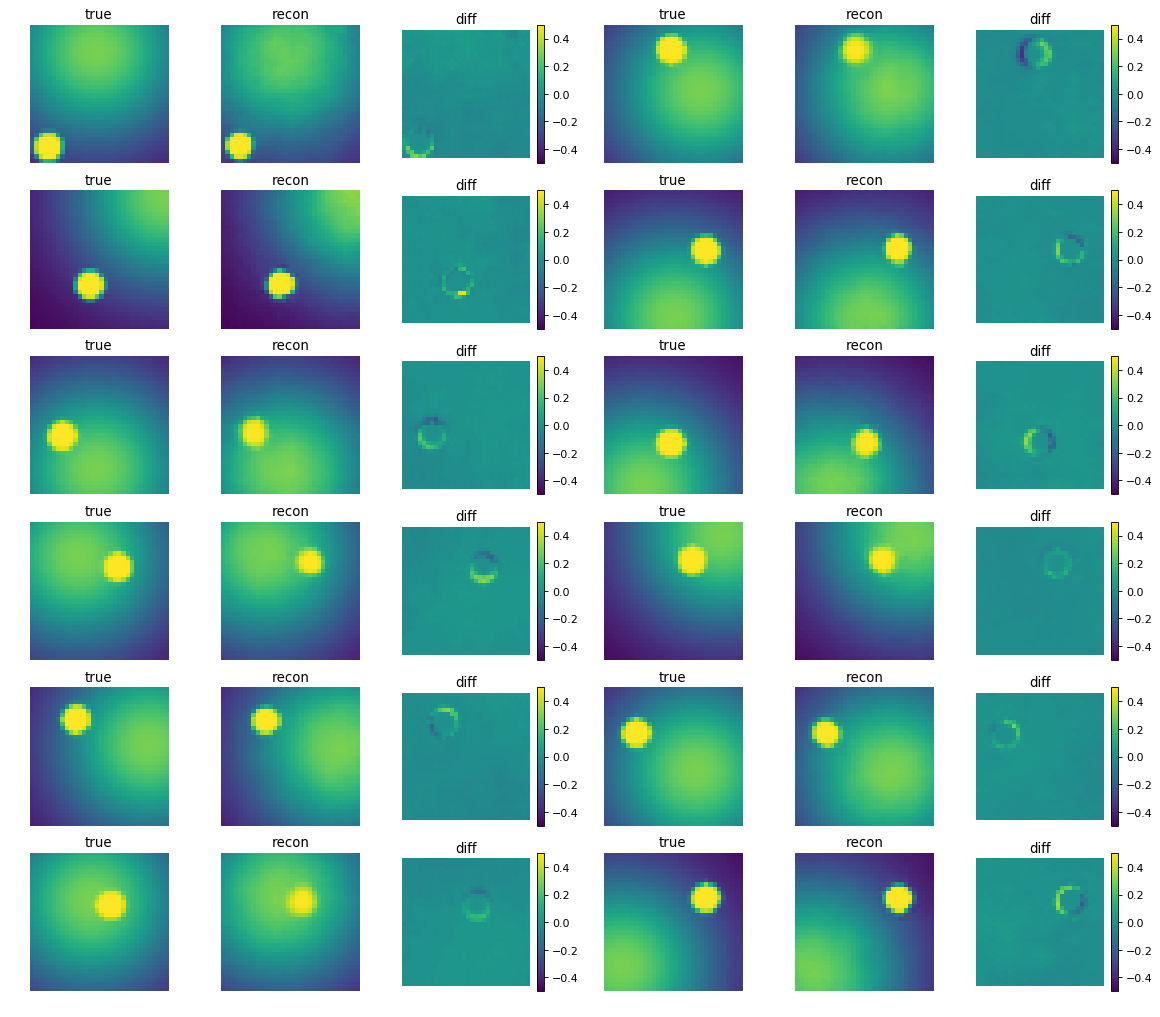

In [10]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
cnt = 0
for ii in range(12):
    x,label = ds[np.random.randint(1000)]
    x = x[np.newaxis, :, :]
    
    recon, mu, logvar = vae(x.float())
    recon = recon.detach()
    diff = x - recon
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)
    ax.imshow(x.squeeze(), vmin=0, vmax=1)
    plt.title('true')
    plt.axis('off')
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)    
    ax.imshow(recon.squeeze(), vmin=0, vmax=1)
    plt.title('recon')
    plt.axis('off')
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)    
    m = .5
    img = ax.imshow(diff.numpy().squeeze(), vmin=-m, vmax=m)
    fig.colorbar(img)
    plt.title('diff')
    plt.axis('off')
    